In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/dataset_pacmann/marketing_AB.csv")

In [25]:
#tampilkan 5 baris teratas di dataset
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


## Data Preprocessing

In [26]:
# Menghapus kolom 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

## Menentukan ukuran sample untuk tiap varian

In [27]:
from scipy.stats import norm

# Fungsi untuk menghitung ukuran sampel
def hitung_ukuran_sampel(alpha, power, std_dev, delta):
    # Hitung Z-scores untuk tingkat signifikansi dan kekuatan
    z_alpha_2 = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)

    # Rumus ukuran sampel
    n = ((z_alpha_2 + z_beta) ** 2 * 2 * (std_dev ** 2)) / (delta ** 2)
    return n

# Parameter input
alpha = 0.05  # Tingkat Signifikansi
power = 0.8   # Kekuatan (1 - beta)
std_dev = 0.05  # Estimasi Standar Deviasi
delta = 0.01   # Perbedaan yang Diharapkan (1% peningkatan konversi)

# Hitung ukuran sampel
ukuran_sampel = hitung_ukuran_sampel(alpha, power, std_dev, delta)

# Tampilkan hasil
print(f"Ukuran sampel yang dibutuhkan per varian: {int(ukuran_sampel)} pengguna")

Ukuran sampel yang dibutuhkan per varian: 392 pengguna


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [ ]:
df.shape

(588101, 6)

## **Ukuran Sample**

In [29]:
# Ambil dua grup
group_ad = df[df['test group'] == 'ad']
group_psa = df[df['test group'] == 'psa']

sample_size = 392

print("jumlah sample vaian ad", len(group_ad))
print("jumlah sample vaian psa", len(group_psa))

# Random sampling dari setiap grup
sample_ad = group_ad.sample(n=sample_size, random_state=42)
sample_psa = group_psa.sample(n=sample_size, random_state=42)

print("jumlah sample vaian ad", len(sample_ad))
print("jumlah sample vaian psa", len(sample_psa))

# Gabungkan sampel dari kedua grup
sampled_df = pd.concat([sample_ad, sample_psa])

# Simpan hasil sampel ke file baru (opsional)
sampled_df.to_csv('sampled_dataset.csv', index=False)

# Tampilkan hasil sampel
print(sampled_df.head())

jumlah sample vaian ad 564577
jumlah sample vaian psa 23524
jumlah sample vaian ad 392
jumlah sample vaian psa 392
        user id test group  converted  total ads most ads day  most ads hour
529666  1300427         ad      False         21       Friday             20
385537  1197483         ad      False          2     Thursday             20
120467  1234257         ad      False         20       Sunday             10
186608  1384841         ad       True         47       Friday             14
141292  1646962         ad      False         13      Tuesday             13


In [30]:
sampled_df

,user id,test group,converted,total ads,most ads day,most ads hour
529666,1300427,ad,False,21,Friday,20
385537,1197483,ad,False,2,Thursday,20
120467,1234257,ad,False,20,Sunday,10
186608,1384841,ad,True,47,Friday,14
141292,1646962,ad,False,13,Tuesday,13
...,...,...,...,...,...,...
5094,909630,psa,False,10,Friday,20
155170,901271,psa,False,42,Saturday,11
217154,919825,psa,False,14,Thursday,12
1290,923392,psa,False,76,Thursday,19


In [31]:
# Parameter
n_required_per_group = 392  # Ukuran sampel per grup
total_users_required = n_required_per_group * 2  # Ukuran sampel total (kontrol + treatment)

# Asumsi
daily_traffic = 1000  # Misalnya rata-rata jumlah pengguna per hari
traffic_allocation_ratio = 0.5  # 50% untuk masing-masing grup

# Hitung waktu yang diperlukan
days_required = total_users_required / (daily_traffic * traffic_allocation_ratio)

print(f"Estimasi waktu pengujian: {days_required:.2f} hari")

Estimasi waktu pengujian: 1.57 hari


## **Trustworthiness Data**

1.   Mengidentifikasi data yang hilang
2.   Mengidentifikasi data yang duplikat
3.   Mengecek distribusi data



In [32]:
import numpy as np

# Cek nilai yang hilang
missing_values = sampled_df.isnull().sum()

# Cek data duplikat
duplicates = sampled_df.duplicated().sum()

print("Nilai yang Hilang:\n", missing_values)
print("\nData Duplikat:\n", duplicates)

Nilai yang Hilang:
 user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Data Duplikat:
 0


<ipython-input-33-e9dfe3dd7543>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='most ads day', data=sampled_df, order=sampled_df['most ads day'].value_counts().index, palette='viridis')


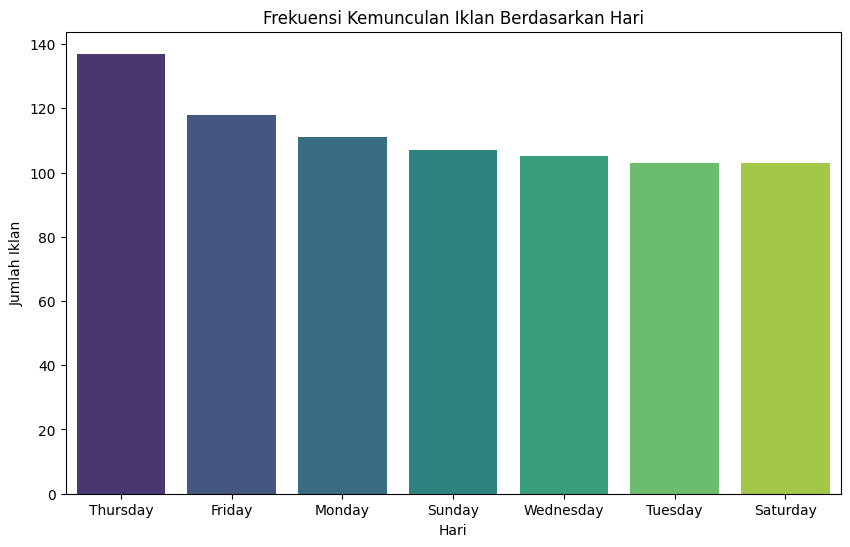

In [33]:
# Frekuensi kemunculan iklan berdasarkan hari
plt.figure(figsize=(10, 6))
sns.countplot(x='most ads day', data=sampled_df, order=sampled_df['most ads day'].value_counts().index, palette='viridis')
plt.title('Frekuensi Kemunculan Iklan Berdasarkan Hari')
plt.xlabel('Hari')
plt.ylabel('Jumlah Iklan')
plt.show()

<ipython-input-34-be30ab6fadbd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='most ads hour', data=sampled_df, order=sampled_df['most ads hour'].value_counts().index, palette='viridis')


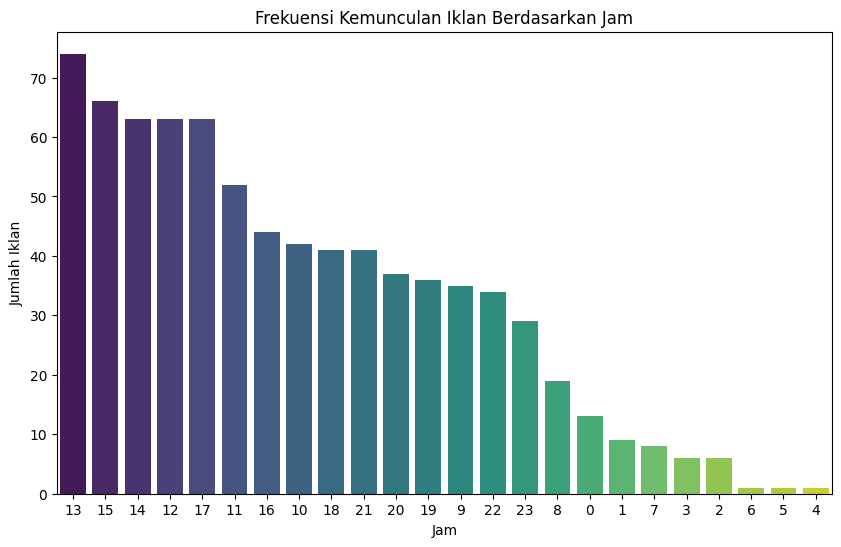

In [34]:
plt.figure(figsize=(10, 6))
sns.countplot(x='most ads hour', data=sampled_df, order=sampled_df['most ads hour'].value_counts().index, palette='viridis')
plt.title('Frekuensi Kemunculan Iklan Berdasarkan Jam')
plt.xlabel('Jam')
plt.ylabel('Jumlah Iklan')
plt.show()

## **Data Exploration**

In [35]:
# Jumlah user pada masing-masing grup
group_counts = sampled_df['test group'].value_counts()

# Insight lain (misalnya rata-rata konversi per grup)
conversion_rate_per_group = sampled_df.groupby('test group')['converted'].mean()

print("Jumlah User pada Masing-masing Grup:\n", group_counts)
print("\nRata-rata Konversi per Grup:\n", conversion_rate_per_group)


Jumlah User pada Masing-masing Grup:
 test group
ad     392
psa    392
Name: count, dtype: int64

Rata-rata Konversi per Grup:
 test group
ad     0.020408
psa    0.015306
Name: converted, dtype: float64


<ipython-input-36-592e50681a34>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='test group', y='converted', data=conversion_rate_per_group, palette='viridis')


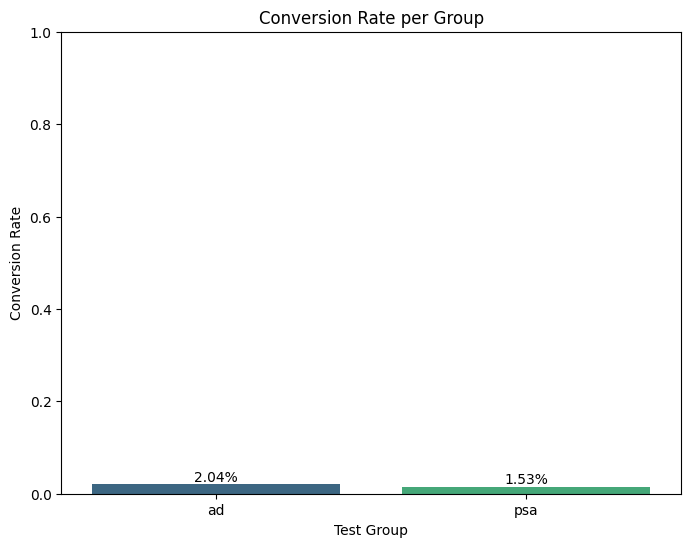

In [36]:
# Hitung rata-rata konversi per grup
conversion_rate_per_group = sampled_df.groupby('test group')['converted'].mean().reset_index()

# Plot menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='test group', y='converted', data=conversion_rate_per_group, palette='viridis')
plt.xlabel('Test Group')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Group')
plt.ylim(0, 1)
for i, rate in enumerate(conversion_rate_per_group['converted']):
    plt.text(i, rate, f"{rate:.2%}", ha='center', va='bottom')

plt.show()

## **SRM Test dengan Chi-Square Test**

In [39]:
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportion_confint

# Observasi aktual
obs = group_counts.values

# Jumlah total pengguna
total_users = sampled_df.shape[0]

# Harapan proporsi pengguna (seharusnya sama)
expected_proportion = [total_users / 2, total_users / 2]

# Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency([obs, expected_proportion])

print("Chi-square Test Statistic:", chi2_stat)
print("P-Value:", p_val)

if p_val < 0.05:
    print("Terdapat Sample Ratio Mismatch (SRM)")
else:
    print("Tidak terdapat Sample Ratio Mismatch (SRM)")


Chi-square Test Statistic: 0.0
P-Value: 1.0
Tidak terdapat Sample Ratio Mismatch (SRM)


## **Hypothesis Testing**

In [41]:
# Menghitung konversi per grup
conversion_counts = sampled_df.groupby('test group')['converted'].sum().values
from statsmodels.stats.proportion import proportions_ztest

# Menghitung total pengguna per grup
nobs = sampled_df['test group'].value_counts().values

# Hipotesis
print("Hipotesis:")
print("H0: Conversion rate iklan = conversion rate PSA")
print("H1: Conversion rate iklan > conversion rate PSA")
print()

# Uji proporsi satu arah
z_stat, p_val = proportions_ztest(conversion_counts, nobs, alternative='larger')

print("Z-Test Statistic:", z_stat)
print("P-Value:", p_val)

# Interpretasi hasil
alpha = 0.05
if p_val < alpha:
    print("Kesimpulan: Tolak H0. Conversion rate iklan lebih besar daripada conversion rate PSA.")
else:
    print("Kesimpulan: Gagal menolak H0. Tidak ada bukti cukup bahwa conversion rate iklan lebih besar daripada conversion rate PSA.")

Hipotesis:
H0: Conversion rate iklan = conversion rate PSA
H1: Conversion rate iklan > conversion rate PSA

Z-Test Statistic: 0.5393598899705936
P-Value: 0.2948192758132836
Kesimpulan: Gagal menolak H0. Tidak ada bukti cukup bahwa conversion rate iklan lebih besar daripada conversion rate PSA.


## **Menghitung confidential Interval**

In [42]:
from statsmodels.stats.proportion import proportion_confint

# Konversi per grup
conversion_counts = sampled_df.groupby('test group')['converted'].sum().values

# Total pengguna per grup
nobs = sampled_df['test group'].value_counts().values

# Hitung tingkat konversi
conversion_rates = conversion_counts / nobs

# Confidence interval untuk setiap grup
ci_iklan = proportion_confint(conversion_counts[0], nobs[0], alpha=0.05)
ci_psa = proportion_confint(conversion_counts[1], nobs[1], alpha=0.05)

# Perbedaan konversi dan CI perbedaan
difference = conversion_rates[0] - conversion_rates[1]
se_diff = np.sqrt((conversion_rates[0] * (1 - conversion_rates[0]) / nobs[0]) +
                  (conversion_rates[1] * (1 - conversion_rates[1]) / nobs[1]))
z_score = 1.96  # for 95% CI
ci_diff = (difference - z_score * se_diff, difference + z_score * se_diff)

print("Conversion rate iklan:", conversion_rates[0])
print("Conversion rate PSA:", conversion_rates[1])
print("Difference in conversion rates:", difference)
print("95% Confidence Interval for the difference:", ci_diff)

Conversion rate iklan: 0.02040816326530612
Conversion rate PSA: 0.015306122448979591
Difference in conversion rates: 0.005102040816326529
95% Confidence Interval for the difference: (-0.013435015287046298, 0.023639096919699357)


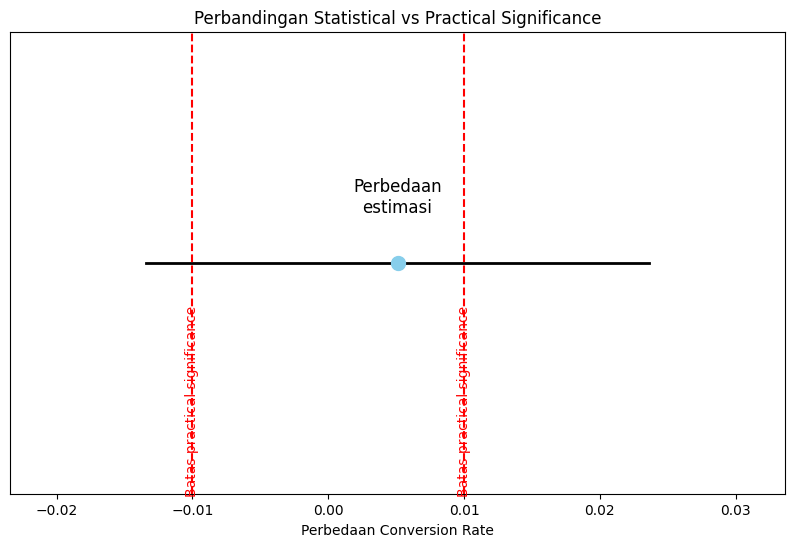

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Data untuk plotting
difference = conversion_rates[0] - conversion_rates[1]
ci_diff_lower, ci_diff_upper = ci_diff

# Tentukan batas practical significance
practical_significance_threshold = 0.01  # Misalnya 1%

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Perbedaan estimasi dan CI
ax.plot([ci_diff_lower, ci_diff_upper], [0, 0], color='black', lw=2)  # CI Line
ax.scatter([difference], [0], color='skyblue', s=100, zorder=3)  # Point Estimate
ax.text(difference, 0.01, 'Perbedaan\nestimasi', ha='center', va='bottom', fontsize=12, color='black', zorder=4)

# Batas practical significance
ax.axvline(x=-practical_significance_threshold, color='red', linestyle='--', lw=1.5, label='Batas practical significance')
ax.axvline(x=practical_significance_threshold, color='red', linestyle='--', lw=1.5)

# Tambahan label pada batas practical significance
ax.text(-practical_significance_threshold, -0.03, 'Batas practical significance', ha='center', va='center', rotation='vertical', fontsize=10, color='red')
ax.text(practical_significance_threshold, -0.03, 'Batas practical significance', ha='center', va='center', rotation='vertical', fontsize=10, color='red')

# Labels dan Titles
ax.set_title('Perbandingan Statistical vs Practical Significance')
ax.set_xlabel('Perbedaan Conversion Rate')
ax.set_ylabel('')
ax.set_yticks([])  # Menghapus ticks di y-axis
ax.grid(False)

# Setting limit
ax.set_xlim(ci_diff_lower - 0.01, ci_diff_upper + 0.01)
ax.set_ylim(-0.05, 0.05)

# Show Plot
plt.show()
